In [1]:
from importnb import Notebook

with Notebook():
    from DataClass import DataSet
    from DeepLabModel import Deeplabv3Plus
    from Utils import save_checkpoint, load_checkpoint, get_data_loaders,calculate_epoch_accuracy, calculate_validation_loss, calculate_miou

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2;
from tqdm import tqdm
from torch.optim.lr_scheduler import OneCycleLR

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

###### HyperParameters

In [20]:
LEARNING_RATE = 1e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 8 #8
NUM_EPOCHS = 8
WEIGHT_DECAY = 1e-4
IMAGE_HEIGHT = 320 #320
IMAGE_WIDTH = 480 #480
LOAD_MODEL = True ##HEREE
TRAIN_IMG_DIR = 'C:\\Users\\georg\\Desktop\\Segmentation_data\\train\\images'
TRAIN_MASK_DIR = 'C:\\Users\\georg\\Desktop\\Segmentation_data\\train\\labels'
VAL_IMG_DIR = 'C:\\Users\\georg\\Desktop\\Segmentation_data\\validation\\images'
VAL_MASK_DIR = 'C:\\Users\\georg\\Desktop\\Segmentation_data\\validation\\lables'

###### Augmentation and Transformation Function

In [8]:
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(), 
    ]
)

###### Train Loops

In [21]:
def train_fn(loader, model, optimizer, loss_fn, epoch, num_epochs):
    model.train()
    loop = tqdm(loader)
    

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.long().to(device=DEVICE)

        # forward pass
        predictions = model.forward(data)
        loss = loss_fn(predictions, targets)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sched.step()
        
        # update tqdm loop
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())
        
        

In [22]:
model = Deeplabv3Plus(10,False,False).to(DEVICE)  ##False False

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [11]:
train_loader, val_loader = get_data_loaders(
    TRAIN_IMG_DIR,
    TRAIN_MASK_DIR,
    VAL_IMG_DIR,
    VAL_MASK_DIR,
    BATCH_SIZE,
    train_transform,
    val_transform
)

In [12]:
len(train_loader)

113

In [23]:
if LOAD_MODEL:
    load_checkpoint(torch.load('my_checkpoint.pth.tar'), model)

C:\Users\georg\AppData\Local\Temp\ipykernel_9080\2023337754.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_checkpoint(torch.load('my_checkpoint.pth.tar'), model)


=> Loading checkpoint


###### Scheduler with built in warm up ramp

In [24]:
sched = OneCycleLR(optimizer, max_lr=LEARNING_RATE, epochs=NUM_EPOCHS, steps_per_epoch=len(train_loader))

###### Writer

In [13]:
writer = SummaryWriter(f"runs/DeepLab/Trial")

In [14]:
val_acc=[]
val_loss=[]
val_miou=[]

In [25]:
step=7
for epoch in range(NUM_EPOCHS):
    
    train_fn(train_loader, model, optimizer, loss_fn, epoch,NUM_EPOCHS)
    
    accuracy = calculate_epoch_accuracy(model, val_loader, device=DEVICE)
    loss = calculate_validation_loss(model, val_loader , loss_fn, device=DEVICE)
    miou = calculate_miou(model,val_loader,device=DEVICE,num_classes=10)
    
    writer.add_scalar("Loss/Validation",loss, global_step=step)
    
    writer.add_scalar("Acc/Validation",accuracy, global_step=step)
    writer.add_scalar("mIOU/Vallidation",miou, global_step=step)
    step+=1
    
    val_acc.append(accuracy)
    val_loss.append(loss)
    val_miou.append(miou)
    print(f"Accuracy {accuracy}, avg val loss {loss}, mIOU {miou} ")

    # save model
    checkpoint = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)    

Epoch [1/8]: 100%|██████████| 113/113 [05:38<00:00,  3.00s/it, loss=0.145] 


Accuracy 0.9637050130208333, avg val loss 0.1018133693589614, mIOU 0.6534228420573818 
=> Saving checkpoint


Epoch [2/8]: 100%|██████████| 113/113 [06:02<00:00,  3.21s/it, loss=0.0968]


Accuracy 0.9576035807291666, avg val loss 0.11940779794867222, mIOU 0.6291439545787236 
=> Saving checkpoint


Epoch [3/8]: 100%|██████████| 113/113 [05:50<00:00,  3.11s/it, loss=0.184] 


Accuracy 0.9643303385416667, avg val loss 0.09867584046262962, mIOU 0.6529164326554661 
=> Saving checkpoint


Epoch [4/8]: 100%|██████████| 113/113 [05:50<00:00,  3.10s/it, loss=0.14]  


Accuracy 0.9649970052083333, avg val loss 0.10018876968668057, mIOU 0.6625116352577316 
=> Saving checkpoint


Epoch [5/8]: 100%|██████████| 113/113 [05:50<00:00,  3.10s/it, loss=0.0783]


Accuracy 0.9665345052083333, avg val loss 0.09209637200603119, mIOU 0.6703502133338486 
=> Saving checkpoint


Epoch [6/8]: 100%|██████████| 113/113 [05:53<00:00,  3.13s/it, loss=0.186] 


Accuracy 0.9672858723958333, avg val loss 0.09000866487622261, mIOU 0.6698430743818223 
=> Saving checkpoint


Epoch [7/8]: 100%|██████████| 113/113 [05:50<00:00,  3.10s/it, loss=0.151] 


Accuracy 0.9673274088541667, avg val loss 0.08957927100933515, mIOU 0.6740653320527771 
=> Saving checkpoint


Epoch [8/8]: 100%|██████████| 113/113 [05:49<00:00,  3.09s/it, loss=0.129] 


Accuracy 0.9675925130208334, avg val loss 0.08884964682734929, mIOU 0.6742841970954901 
=> Saving checkpoint


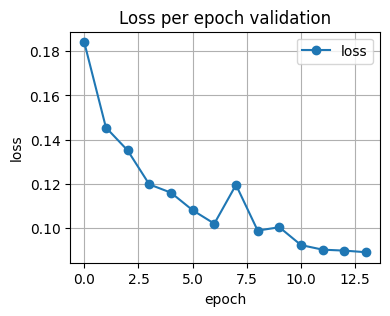

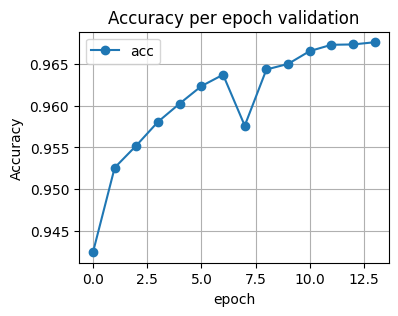

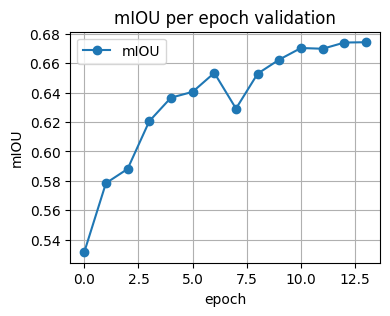

In [48]:
plt.figure(figsize=(4, 3))
plt.plot(val_loss, label='loss', marker='o')
plt.title('Loss per epoch validation'); plt.ylabel('loss');
plt.xlabel('epoch')
plt.legend(), plt.grid()
plt.show()

plt.figure(figsize=(4, 3))
plt.plot(val_acc, label='acc', marker='o')
plt.title('Accuracy per epoch validation'); plt.ylabel('Accuracy');
plt.xlabel('epoch')
plt.legend(), plt.grid()
plt.show()

plt.figure(figsize=(4, 3))
plt.plot(val_miou, label='mIOU', marker='o')
plt.title('mIOU per epoch validation'); plt.ylabel('mIOU');
plt.xlabel('epoch')
plt.legend(), plt.grid()
plt.show()